# compare the GT and the extracted data

## copy the json from all set

In [27]:
import glob
import os
import shutil
# get a list of all *.html in app\static\data\matched
html_files = glob.glob('../app/static/data/matched/matched/*.html')
json_files = [os.path.basename(file[:-5]+".json") for file in html_files ]
json_files = set(json_files)

# get a set of all *.json in ../app/static/data/jsons
json_files_all = glob.glob('../app/static/data/jsons/*.json')
json_files_all = [os.path.basename(file) for file in json_files_all]
json_files_all = set(json_files_all)

# find the intersection of the two sets
json_intersection = json_files.intersection(json_files_all)
assert len(json_intersection) == len(json_files), "All json files are already present in ../app/static/data/jsons"



In [15]:
print("EPC2007C_datasheet_p2f1.json" in json_files_all)
print("EPC2007C_datasheet_p2f1.json" in json_files)
print("EPC2007C_datasheet_p2f1.json" in json_intersection)

True
True
True


In [21]:
# use shutil to copy intersected json files to ../app/static/data/matched/matched/
project_dir = "D:\\workspace\\PowerBrain\\annotation_gt"
for file in json_intersection:
    shutil.copy(os.path.join(project_dir,'app/static/data/jsons/'+file), os.path.join(project_dir,'app/static/data/matched/matched/'+file))
    print("Copied "+file)

Copied EPC2044_datasheet_p2f4.json
Copied EPC7019_datasheet_p3f5.json
Copied EPC2619_datasheet_p2f4.json
Copied epc2055_datasheet_p2f1.json
Copied EPC7007_datasheet_p2f3.json
Copied EPC2020_datasheet_p3f3.json
Copied EPC2221_datasheet_p2f4.json
Copied EPC2023_datasheet_p3f5.json
Copied EPC2070_datasheet_p2f2.json
Copied EPC2007C_datasheet_p3f1.json
Copied EPC2110_datasheet_p3f5.json
Copied EPC2007C_datasheet_p2f1.json
Copied EPC7004_datasheet_p3f5.json
Copied EPC2214_datasheet_p3f4.json
Copied EPC2216_datasheet_p2f3.json
Copied EPC2111_datasheet_p3f3.json
Copied EPC2040_datasheet_p3f1.json
Copied EPC2308_datasheet_p2f4.json
Copied EPC2020_datasheet_p4f1.json
Copied EPC2105_datasheet_p4f1.json
Copied EPC2308_datasheet_p2f1.json
Copied epc2055_datasheet_p3f4.json
Copied EPC2039_datasheet_p3f1.json
Copied EPC2619_datasheet_p3f1.json
Copied EPC2215_datasheet_p2f2.json
Copied EPC2216_datasheet_p2f1.json
Copied EPC7003_datasheet_p2f2.json
Copied EPC2029_datasheet_p2f2.json
Copied EPC2045_dat

## compare the GT and the extracted data 

### data prepration 

In [8]:
# extract data from json file
import json
import re
import os
import shutil
import glob
import numpy as np

# evaluate the interpolation result from a ground truth and an extracted data
from scipy.interpolate import interp1d
from scipy.spatial import distance
import tqdm





In [30]:
# extract ground truth data from json files to npz files
json_intersection = glob.glob('../app/static/data/matched/matched/*.json')
json_intersection = [os.path.basename(file) for file in json_intersection]

for file in json_intersection:
    with open('../app/static/data/matched/matched/'+file, 'r') as f:
        data = json.load(f)
    result = []
    for item in data['data']:
        x = item['x']
        y = item['y']
        assert len(x) == len(y), "x and y have different lengths"
        arr = np.array([x,y],dtype=np.float64).T
        result.append(arr)
    np.savez("../app/static/data/matched/matched/"+file[:-5]+"_gt.npz",*result)



### compare data

In [5]:
def intersection(gt_arr, extract_arr):
    # find the intersection of the two arrays in terms of range of x , keep only intersection points only for gt_arr
    # make sure that the range of x for gt_arr is within the range of x for extract_arr
    x_min = max(gt_arr[0,0], extract_arr[0,0])
    x_max = min(gt_arr[-1,0], extract_arr[-1,0])
    gt_arr = gt_arr[(gt_arr[:,0] >= x_min) & (gt_arr[:,0] <= x_max)]

    # if intersection is empty, return None
    if len(gt_arr) == 0:
        return None, extract_arr
    return gt_arr, extract_arr

def evaluate(gt_arr, extract_arr,intersectionCheck=True,scaler=None):
    # evalueate the interpolation result from a ground truth and an extracted data
    # loss : \sum_{i=0}^{N}\frac{1}{N}\frac{|\hat{y}^i-y_{gt}^i|}{\min{\vec{y}_{gt}}-\max{\vec{y}_{gt}}}

    if intersectionCheck:
        # use the intersection function to find the intersection of the two arrays
        gt_arr_intersected, extract_arr = intersection(gt_arr, extract_arr)
        if gt_arr_intersected is None:
            return np.inf
    else:
        gt_arr_intersected = gt_arr
    # if gt_arr_intersected is too small or extract_arr is empty, return Inf, as the evaluation is not possible
    if len(gt_arr_intersected) <= 3 or len(extract_arr) == 0:
        return np.inf
    
    # interpolate the gt data on extract_arr x values
    f = interp1d(extract_arr[:,0], extract_arr[:,1], kind='linear', fill_value='extrapolate')

    # evaluate the interpolation result based on means of absolute differences
    if not scaler:
        scaler = np.max(gt_arr_intersected[:,1])-np.min(gt_arr_intersected[:,1])
    else:
        scaler = scaler
    gt_arr_interp = f(gt_arr_intersected[:,0])
    loss = np.mean(np.abs(gt_arr_intersected[:,1]-gt_arr_interp)/(scaler))
    # calculate the loss 

    return loss



In [103]:
# EPC2040_datasheet_p2f2 49
# EPC2101_datasheet_p3f1 48
# EPC2111_datasheet_p3f1 13%
# EPC2308_datasheet_p2f1 17
# EPC7020_datasheet_p3f3 34%
datafile = "EPC2007C_datasheet_p3f4"


In [104]:
# extracted GT data from json file
gt_arr_list_file = np.load(f"..\\app\\static\\data\\matched\\matched\\{datafile}_gt.npz")
gt_arr_list = []
for i in range(len(gt_arr_list_file.files)):
    gt_arr_list.append(gt_arr_list_file[gt_arr_list_file.files[i]]) 
gt_arr_list_file.close()

# extract powerbrain data from npz file
extract_arr_list_file = np.load(f"..\\app\\static\\data\\matched\\matched\\{datafile}.npz")
extract_arr_list = []
for i in range(len(extract_arr_list_file.files)):
    extract_arr_list.append(extract_arr_list_file[extract_arr_list_file.files[i]])
extract_arr_list_file.close()

In [106]:
loss_matrix = np.zeros((len(gt_arr_list),len(extract_arr_list)))
# the dimension of the loss matrix is len(gt_arr_list) x len(extract_arr_list)
# number of ground truth arrays

scaler = 0
for i in range(len(gt_arr_list)):
    scaler = max(scaler, np.max(gt_arr_list[i][:,1])-np.min(gt_arr_list[i][:,1]))

for i in range(len(gt_arr_list)):  
    for j in range(len(extract_arr_list)):
        loss_matrix[i,j] = evaluate(gt_arr_list[i], extract_arr_list[j],scaler=scaler)

losses = np.min(loss_matrix,axis=1) # get the minimum loss for each ground truth array
mean_loss = np.mean(losses,axis=0) # get the mean of the minimum losses


# with open("mean_relative_abs_loss_record.txt","w") as f:
#     f.write(f"EPC2007C_datasheet_p2f1\t{mean_loss}\n")

In [107]:
loss_matrix

array([[inf, inf],
       [inf, inf]])

In [95]:
losses_vertical = np.min(loss_matrix,axis=1)
losses_vertical = losses_vertical[losses_vertical != np.inf] # remove inf values
losses_horizontal = np.min(loss_matrix,axis=0)
losses_horizontal = losses_horizontal[losses_horizontal != np.inf] # remove inf values


In [96]:
losses_vertical

array([0.01434812])

In [97]:
losses_horizontal

array([0.01434812, 0.7128124 , 0.28033387])

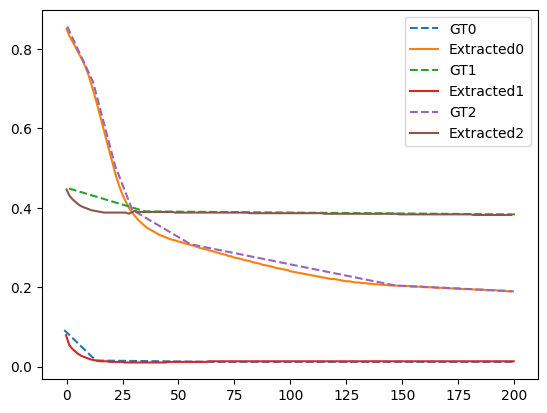

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# plot the gt_arr_list.files
for i in range(len(gt_arr_list)):
    ax.plot(gt_arr_list[i][:,0],gt_arr_list[i][:,1],label="GT"+str(i),linestyle='dashed')
    ax.plot(extract_arr_list[i][:,0],extract_arr_list[i][:,1],label="Extracted"+str(i))
ax.legend()

In [14]:
print(gt_arr_list.files[0])
print(gt_arr_list[gt_arr_list.files[0]].shape)
arr_0 = gt_arr_list[gt_arr_list.files[0]]
print(arr_0)


arr_0
(4, 2)
[[ 1.30934087e-04 -8.84998086e-04]
 [ 4.09299957e-01  1.63888012e+01]
 [ 8.69887888e-01  3.19910783e+01]
 [ 1.15581520e+00  4.00280568e+01]]


In [41]:
# for every json file in the matched folder, evaluate the interpolation result
# and save the result in a txt file
npz_files_dir = "../app/static/data/matched/matched/"
json_intersection = glob.glob(npz_files_dir+"*.json")
json_intersection = [os.path.basename(file) for file in json_intersection]
gt_arr_list_files = [file[:-5]+"_gt.npz" for file in json_intersection]
extract_arr_list_files = [file[:-5]+".npz" for file in json_intersection]
assert len(gt_arr_list_files) == len(extract_arr_list_files), "gt_arr_list_files and extract_arr_list_files have different lengths"

def mean_realative_abs_loss(gt_arr_list, extract_arr_list):
    loss_matrix = np.zeros((len(gt_arr_list),len(extract_arr_list)))
    scaler = 0
    for i in range(len(gt_arr_list)):
        scaler = max(scaler, np.max(gt_arr_list[i][:,1])-np.min(gt_arr_list[i][:,1]))

    for i in range(len(gt_arr_list)):
        for j in range(len(extract_arr_list)):
            loss_matrix[i,j] = evaluate(gt_arr_list[i], extract_arr_list[j],scaler=scaler)
    
    losses_vertical = np.min(loss_matrix,axis=1)
    losses_vertical = losses_vertical[losses_vertical != np.inf] # remove inf values
    losses_horizontal = np.min(loss_matrix,axis=0)
    losses_horizontal = losses_horizontal[losses_horizontal != np.inf] # remove inf values
    if len(losses_vertical) == len(losses_horizontal):
        # normal case
        losses = losses_vertical
    elif len(losses_vertical) > len(losses_horizontal):
        losses = losses_horizontal
    else:
        losses = losses_vertical
    mean_loss = np.mean(losses)
    if np.isnan(mean_loss):
        mean_loss = np.inf
    return mean_loss


In [ ]:

for gt_arr_list_filename, extract_arr_list_filename in tqdm.tqdm(zip(gt_arr_list_files,extract_arr_list_files)):
    # extracted GT data from npz file
    gt_arr_list_file = np.load(npz_files_dir+gt_arr_list_filename)
    gt_arr_list = []
    for i in range(len(gt_arr_list_file.files)):
        gt_arr_list.append(gt_arr_list_file[gt_arr_list_file.files[i]])
    gt_arr_list_file.close()

    # extract powerbrain data from npz file
    extract_arr_list_file = np.load(npz_files_dir+extract_arr_list_filename)
    extract_arr_list = []
    for i in range(len(extract_arr_list_file.files)):
        extract_arr_list.append(extract_arr_list_file[extract_arr_list_file.files[i]])
    extract_arr_list_file.close()

    # evaluate the mean relative absolute loss
    mean_loss = mean_realative_abs_loss(gt_arr_list, extract_arr_list)
    with open("mean_relative_abs_loss_record.txt","a") as f:
        f.write(f"{gt_arr_list_filename[:-7]}\t{mean_loss}\n")
    


In [ ]:
figure_dir = "C:\\Users\\11275\\Downloads\\figures\\figures\\"

### postprocess of results

In [69]:
# read the mean_relative_abs_loss_record.txt file calculate the mean of the mean relative absolute loss
with open("mean_relative_abs_loss_record.txt","r") as f:
    lines = f.readlines()
    mean_losses = []
    for line in lines:
        mean_losses.append(float(line.split("\t")[1]))
    mean_losses = np.array(mean_losses)
    mean_mean_loss = np.mean(mean_losses)

In [70]:
# remove inf values from the mean_losses
mean_losses = mean_losses[mean_losses != np.inf]
mean_mean_loss = np.mean(mean_losses)

In [71]:
print(mean_mean_loss)

0.015834221254877746


## Get the LineEX data prepared

In [144]:
figure_path = "C:\\Users\\11275\\Downloads\\figures\\figures\\*.png"
json_intersection = glob.glob("../app/static/data/matched/matched/*.json")
json_intersection = [os.path.basename(file) for file in json_intersection]
target_figure_files = []
figure_files = glob.glob(figure_path)
figure_files = [os.path.basename(file) for file in figure_files]

# convert EPC2007C_datasheet_p2f1 to EPC2007_page_2_0.png to match the figure files. note that the page number is 1-based, while the figure files are 0-based
for file in json_intersection:
    page = re.search(r"_p\d+f\d",file).group(0)
    page = page[2:]
    page = page.split("f")
    page = page[0]+"_"+str(int(page[1])-1)
    pageNum, figNum = page.split("_")
    # generate the figure file name from the json file name
    elements = file.split("_")
    new_file = elements[0]+"_"+f"page_{page}.png"
    if new_file not in figure_files:
        print("Not found")
        continue
    target_figure_files.append(new_file)



Not found
Not found
Not found
Not found


In [171]:
figure_dir = "../app/static/data/matched/matched/"
origin_dir = "C:\\Users\\11275\\Downloads\\figures\\figures\\"
intersection_files = set(figure_files).intersection(set(target_figure_files))
# copy the target figure files to the figure directory
for file in intersection_files:       
    file_elements = file.split("_")
    pageNum = file_elements[2]
    figNum = file_elements[3][:-4]
    new_file = file_elements[0]+"_"+"datasheet_"+f"p{pageNum}f{int(figNum)+1}.png"
    shutil.copy(origin_dir+file,figure_dir+new_file)
    print("Copied "+origin_dir+file+" to "+figure_dir+new_file)

Copied C:\Users\11275\Downloads\figures\figures\EPC2070_page_2_1.png to ../app/static/data/matched/matched/EPC2070_datasheet_p2f2.png
Copied C:\Users\11275\Downloads\figures\figures\EPC2024_page_4_0.png to ../app/static/data/matched/matched/EPC2024_datasheet_p4f1.png
Copied C:\Users\11275\Downloads\figures\figures\EPC2252_page_2_0.png to ../app/static/data/matched/matched/EPC2252_datasheet_p2f1.png
Copied C:\Users\11275\Downloads\figures\figures\epc2302_page_3_2.png to ../app/static/data/matched/matched/epc2302_datasheet_p3f3.png
Copied C:\Users\11275\Downloads\figures\figures\EPC2307_page_3_4.png to ../app/static/data/matched/matched/EPC2307_datasheet_p3f5.png
Copied C:\Users\11275\Downloads\figures\figures\EPC7014_page_3_3.png to ../app/static/data/matched/matched/EPC7014_datasheet_p3f4.png
Copied C:\Users\11275\Downloads\figures\figures\EPC2308_page_3_4.png to ../app/static/data/matched/matched/EPC2308_datasheet_p3f5.png
Copied C:\Users\11275\Downloads\figures\figures\EPC2040_page_3

In [167]:
# convert from EPC2007_page_2_0.png format to EPC2007C_datasheet_p2f1
file = "EPC8010_page_4_0.png"
print(new_file)

EPC8010_datasheet_p4f1.png


In [161]:
file

'EPC8010_page_4_0.png'

In [118]:

json_intersection = [re.sub(r"_datasheet_p(\d+)f(\d+)",r"_page_\1_\2",file) for file in json_intersection]
json_intersection = [file[:-5]+".png" for file in json_intersection]

intersected_images = set(json_intersection).intersection(set(figure_files))


In [125]:
json_intersection[0]

'EPC2007C_page_2_1.png'

In [126]:
figure_files[0]

'EPC2001C_page_2_0.png'

### postprocess for LineEX json data

In [39]:
# extract data from json file and save it in npz file "app\static\data\matched\EPC2110_datasheet_p3f4_lineex.json"
import json
import re
import os
import shutil
import glob
import numpy as np

# load the LineEx data from the json file
base_filename = "EPC2007C_datasheet_p2f1"
npz_path = "../app/static/data/matched/matched/"  # the path to save the npz file (powerbrain, gt data)

# load the gt data from the npz file
npz_file = base_filename+"_gt.npz"  
gt_arr_list_file = np.load(npz_path+npz_file)
gt_arr_list = []
for i in range(len(gt_arr_list_file.files)):
    gt_arr_list.append(gt_arr_list_file[gt_arr_list_file.files[i]])
gt_arr_list_file.close()

# load the powerbrain data from the npz file
npz_file = base_filename +".npz"
extract_arr_list_file = np.load(npz_path+npz_file)
extract_arr_list = []
for i in range(len(extract_arr_list_file.files)):
    extract_arr_list.append(extract_arr_list_file[extract_arr_list_file.files[i]])
extract_arr_list_file.close()

# load the LineEx data from the npz file
npz_file = base_filename + "_linex.npz"
linex_arr_list_file = np.load(npz_path+npz_file)
linex_arr_list = []
for i in range(len(linex_arr_list_file.files)):
    linex_arr_list.append(linex_arr_list_file[linex_arr_list_file.files[i]])
linex_arr_list_file.close()


In [54]:
gt_scaler

np.float64(40.18656716417911)

Correlation Matrix
[[0.46850879 0.60284158 0.3159545  0.14340404]
 [0.01961099 0.18076254 0.47718755 0.72140571]
 [0.31517543 0.30754284 0.00903324 0.28280846]
 [0.11943559 0.01528305 0.40358252 0.68872724]]
Min Loss Indices
[1 3 2 0]
Correlation Matrix
[[0.53550435 0.63156624 0.29973188 0.0040346 ]
 [0.12026004 0.01167681 0.37845843 0.65068953]
 [0.01115456 0.14894751 0.36734715 0.56010942]
 [0.33795206 0.35224623 0.00764769 0.30945123]]
Min Loss Indices
[2 1 3 0]


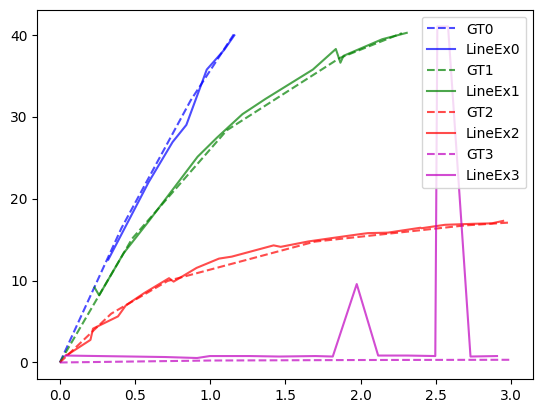

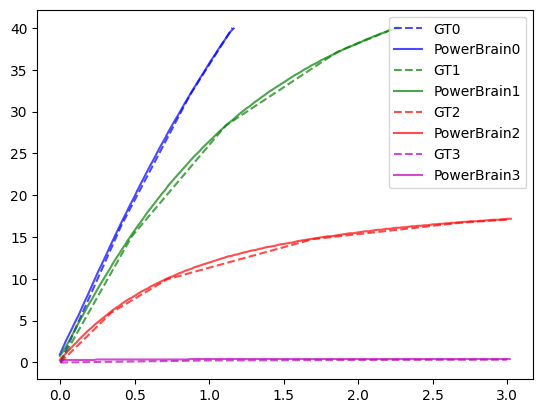

In [55]:
def rearange_linex_powerbrain_data(linex_arr_list,gt_arr_list,visualization=False,name="LineEx",debug=False):
    # find the correlation among the LineEx data, the powerbrain data, and the gt data
    # calculate the correlation between the LineEx data and the gt data
    # 中文介绍：
    # 计算LineEx/Powerbrain数据和gt数据之间的相关性
    # 计算LineEx/Powerbrain数据和gt数据之间的插值误差
    # 重新排列LineEx/PowerBrain数据，使其与gt数据的相关性最好

    correlation_matrix = np.zeros((len(linex_arr_list),len(gt_arr_list)))
    gt_max = 0
    gt_min = np.inf
    for i in range(len(gt_arr_list)):
        gt_max = max(gt_max, np.max(gt_arr_list[i][:,1]))
        gt_min = min(gt_min, np.min(gt_arr_list[i][:,1]))
    scaler = gt_max-gt_min

    for i in range(len(linex_arr_list)):
        for j in range(len(gt_arr_list)):
            # calulate the interpolation error of the LineEx data and the gt data
            loss = evaluate(linex_arr_list[i],gt_arr_list[j],intersectionCheck=True,scaler=scaler)
            correlation_matrix[i,j] = loss

    # rearange LineEx data based on the best corelation with the gt data
    # get the index of the minimum loss for each legend of the LineEx data
    min_loss_indices = np.argmin(correlation_matrix,axis=0)
    # rearange the LineEx data based on the min_loss_indices
    linex_arr_list_rearanged = [linex_arr_list[i] for i in min_loss_indices]
    if debug:
        print("Correlation Matrix")
        print(correlation_matrix)
        print("Min Loss Indices")
        print(min_loss_indices)
    # plot the rearanged LineEx data and the gt data
    # for each legend, use the same color for the LineEx data and the gt data
    colors = ['b','g','r','m','y','c','k']
    if visualization:
        fig, ax = plt.subplots()
        for i in range(len(gt_arr_list)):
            ax.plot(gt_arr_list[i][:,0],gt_arr_list[i][:,1],label="GT"+str(i),linestyle='dashed',color=colors[i],alpha=0.7)
            ax.plot(linex_arr_list_rearanged[i][:,0],linex_arr_list_rearanged[i][:,1],label=name+str(i),color=colors[i],alpha=0.7)
        ax.legend()
    return linex_arr_list_rearanged
rearanged_linex_arr_list = rearange_linex_powerbrain_data(linex_arr_list,gt_arr_list,visualization=True,debug=True,name="LineEx")
rearange_powerbrain_arr_list = rearange_linex_powerbrain_data(extract_arr_list,gt_arr_list,visualization=True,name="PowerBrain",debug=True)

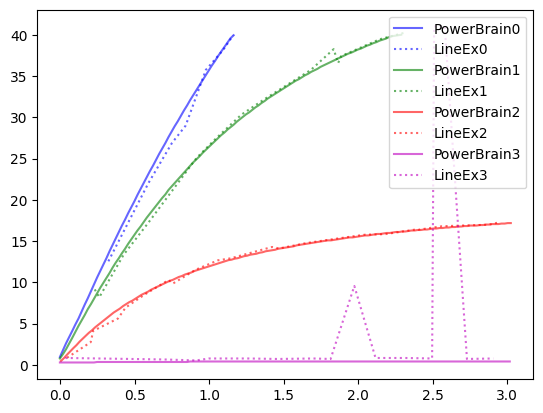

In [59]:
# visualize the data (GT, LineEx, PowerBrain) in a plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plot the gt_arr_list.files, use same color for the same legend based on i
colors = ['b','g','r','m','y','c','k']
for i in range(len(gt_arr_list)):
    # ax.plot(gt_arr_list[i][:,0],gt_arr_list[i][:,1],label="GT"+str(i),linestyle='dashed',color=colors[i],alpha=0.6)
    ax.plot(rearange_powerbrain_arr_list[i][:,0],rearange_powerbrain_arr_list[i][:,1],label="PowerBrain"+str(i),color=colors[i],alpha=0.6)
    ax.plot(rearanged_linex_arr_list[i][:,0],rearanged_linex_arr_list[i][:,1],label="LineEx"+str(i),linestyle='dotted',color=colors[i],alpha=0.6)
    
ax.legend()


In [46]:
# extrat all the data from the json files from lineex and save them in npz files
import json
import re
import os
import shutil
import glob
import numpy as np

# load the LineEx data from the json file
filepath = "../app/static/data/matched/sample_output/"
json_files = glob.glob(filepath+"*.json")
json_files = [os.path.basename(file) for file in json_files]

for json_file in json_files:
    png_file = re.sub(r"pred_data_(.*).json",r"\1",json_file)
    print("Processing "+png_file)
    # LineEx data
    with open (filepath+json_file, 'r') as f:
        data = json.load(f)
    linex_arr_list = []
    for data_per_legend in data["KP_scaled"][png_file]:
        linex_arr_list.append(np.array(data_per_legend,dtype=np.float64))
    np.savez(filepath+png_file[:-4]+"_linex.npz",*linex_arr_list)
    print("Saved "+filepath+png_file[:-4]+"_linex.npz")
    


Processing EPC2007C_datasheet_p2f1.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p2f1_linex.npz
Processing EPC2007C_datasheet_p2f2.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p2f2_linex.npz
Processing EPC2007C_datasheet_p2f3.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p2f3_linex.npz
Processing EPC2007C_datasheet_p3f1.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p3f1_linex.npz
Processing EPC2007C_datasheet_p3f3.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p3f3_linex.npz
Processing EPC2007C_datasheet_p3f4.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p3f4_linex.npz
Processing EPC2007C_datasheet_p4f1.png
Saved ../app/static/data/matched/sample_output/EPC2007C_datasheet_p4f1_linex.npz
Processing EPC2010C_datasheet_p3f1.png
Saved ../app/static/data/matched/sample_output/EPC2010C_datasheet_p3f1_linex.npz
Processing EPC2015C_datasheet_p4f1.png
S

In [51]:
png_file_list_linex= []
for json_file in json_files:
    png_file = re.sub(r"pred_data_(.*).json",r"\1",json_file)
    png_file_list_linex.append(png_file)

# original png files
png_files = glob.glob("../app/static/data/matched/matched/*.png")
png_files = [os.path.basename(file) for file in png_files]

# find the difference between the two sets
png_files = set(png_files)
png_file_list_linex = set(png_file_list_linex)
difference = png_files.difference(png_file_list_linex)

In [53]:
# get a list of all *_linex.npz files
linex_files = glob.glob("../app/static/data/matched/matched/*_linex.npz")
linex_files = [os.path.basename(file) for file in linex_files]

# convert to gt list files
gt_files = [file[:-10]+"_gt.npz" for file in linex_files]

In [66]:

for gt_file, linex_file in zip(gt_files,linex_files):
    # extracted GT data from npz file
    gt_arr_list_file = np.load(npz_files_dir+gt_file)
    gt_arr_list = []
    for i in range(len(gt_arr_list_file.files)):
        gt_arr_list.append(gt_arr_list_file[gt_arr_list_file.files[i]])
    gt_arr_list_file.close()

    # extract LineEX data from npz file
    linex_arr_list_file = np.load(npz_files_dir+linex_file)
    linex_arr_list = []
    for i in range(len(linex_arr_list_file.files)):
        arr = linex_arr_list_file[linex_arr_list_file.files[i]]
        if arr.shape[0] == 0:
            print("Empty array")
        else:
            linex_arr_list.append(arr)
    linex_arr_list_file.close()

    # evaluate the mean relative absolute loss
    mean_loss = mean_realative_abs_loss(gt_arr_list, linex_arr_list)
    with open("mean_relative_abs_loss_record_linex.txt","a") as f:
        f.write(f"{gt_file[:-7]}\t{mean_loss}\n")
 

Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array
Empty array


In [67]:
# read the mean_relative_abs_loss_record_linex.txt file calculate the mean of the mean relative absolute loss
with open("mean_relative_abs_loss_record_linex.txt","r") as f:
    lines = f.readlines()
    mean_losses = []
    for line in lines:
        mean_losses.append(float(line.split("\t")[1]))
    mean_losses = np.array(mean_losses)
    mean_mean_loss = np.mean(mean_losses)
# remove inf values from the mean_losses
mean_losses = mean_losses[mean_losses != np.inf]
mean_mean_loss = np.mean(mean_losses)

In [68]:
print(mean_mean_loss)

0.057380780279886315
